In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import re 
import swifter
import dask.dataframe as dd
from bs4 import BeautifulSoup
from dask import delayed

In [2]:
df=dd.read_csv(r"C:\Users\Neon4\Machine learning code\Data set\Question.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_shape_delayed = delayed(df.shape)

In [5]:
df_shape_delayed.compute()

(404290, 6)

In [6]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 6 entries, id to is_duplicate
dtypes: object(2), int64(4)

In [7]:
df.isnull().sum().compute()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
df=df.dropna().compute()

In [9]:
df['is_duplicate'].value_counts()

is_duplicate
0    255024
1    149263
Name: count, dtype: int64

In [10]:
qid=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
print("no. of unique questions",np.unique(qid).shape[0])

no. of unique questions 537929


In [11]:
x=qid.value_counts()>1
print('no. of question get repeated ',x[x].shape[0])

no. of question get repeated  111778


Text(0.5, 0, 'question repeated ')

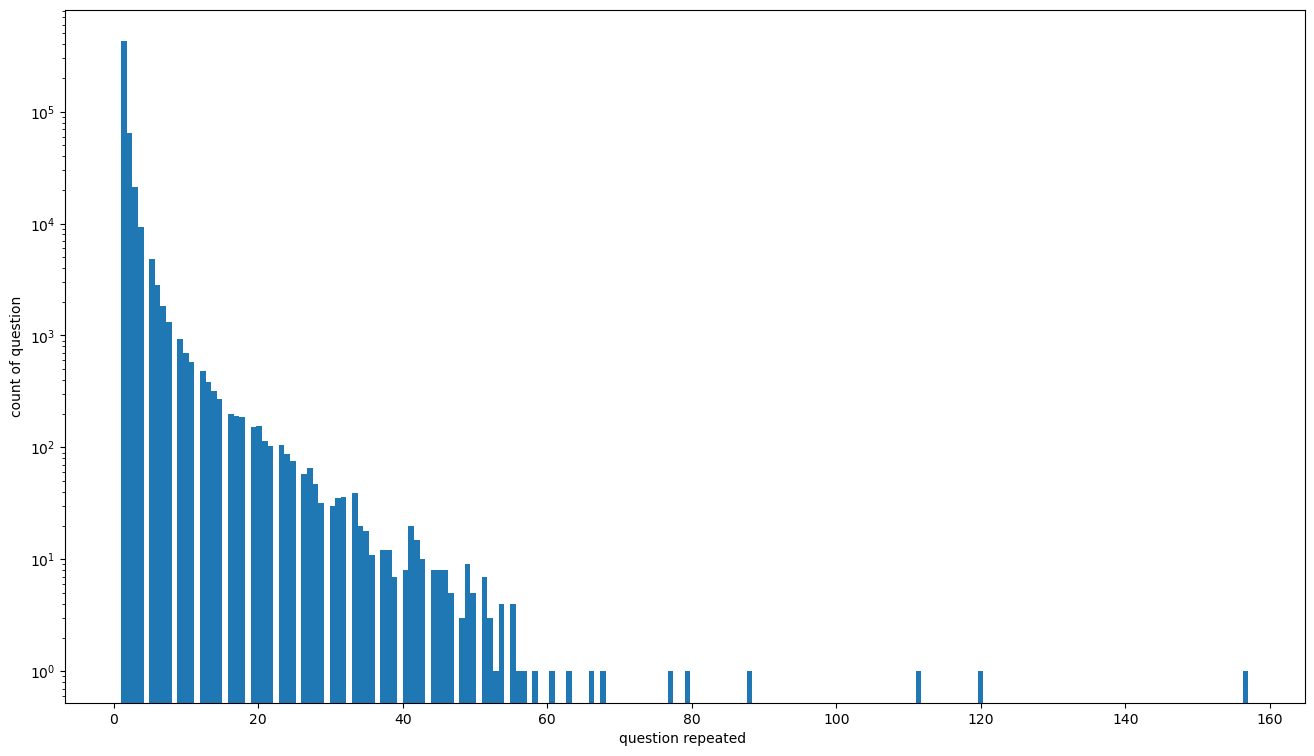

In [12]:
plt.figure(figsize=(16,9))
plt.hist(qid.value_counts().values,bins=200)
plt.yscale('log')
plt.ylabel('count of question')
plt.xlabel('question repeated ')

# Data Preprrocessing

In [13]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    q = q.replace('[math]', '')
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    
     # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [14]:
df['question1'] = df['question1'].swifter.apply(preprocess)
df['question2'] = df['question2'].swifter.apply(preprocess)

Pandas Apply:   0%|          | 0/404287 [00:00<?, ?it/s]

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\2413357511.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)


Pandas Apply:   0%|          | 0/404287 [00:00<?, ?it/s]

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\2413357511.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q)


# Stememing and Lemitaization

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
from nltk.tokenize import word_tokenize
import swifter


In [16]:
stemmer = PorterStemmer()
def stem_text(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    
    return stemmed_text

In [18]:
df['question1'] = df['question1'].swifter.apply(stem_text)
df['question2'] = df['question2'].swifter.apply(stem_text)

Pandas Apply:   0%|          | 0/404287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/404287 [00:00<?, ?it/s]

In [19]:
def apply_lemmatization(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Initialize the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Apply lemmatization to each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the lemmatized words back into a sentence
    lemmatized_text = ' '.join(lemmatized_words)
    
    return lemmatized_text

In [21]:
df['question1'] = df['question1'].swifter.apply(apply_lemmatization)
df['question2'] = df['question2'].swifter.apply(apply_lemmatization)

Pandas Apply:   0%|          | 0/404287 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/404287 [00:00<?, ?it/s]

In [22]:
df.drop(['qid1','qid2','id'],axis=1,inplace=True)

# Feature creation



1 : q1_len = Char length of q1

2 : q2_len = Char length of q2

3 : q1_words = No.of words in q1

4 : q2_words = No.of words in q2

5 : word_common = No. of Common words in q1 and q2

6 : word_total = No. of total worlds in q1 and q2

7 : word_share = word_common / word_total

In [25]:
# q1_len = Char length of q1
# q2_len = Char length of q2

df['q1_len'] = df['question1'].str.len() 
df['q2_len'] = df['question2'].str.len()

In [26]:
# q1_words = No.of words in q1
# q2_words = No.of words in q2
df['q1_num_words'] = df['question1'].apply(lambda row: len(str(row).split(" ")) )
df['q2_num_words'] = df['question2'].apply(lambda row: len(str(row).split(" ")) )

In [27]:
def total_words(row):
    if pd.notna(row['question1']) and pd.notna(row['question2']):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return (len(w1) + len(w2))

In [28]:
# word_common = No. of Common words in q1 and q2
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [29]:
df['word_total'] = df.apply(total_words, axis=1)

In [30]:
df['word_common'] = df[['question1','question2']].apply(common_words, axis=1)


In [31]:
df['word_share'] = round(df['word_common']/df['word_total'],2)


# trming data

In [33]:
df_non=df[df['is_duplicate']==0]
df_dup=df[df['is_duplicate']==1]

(array([14261.,     0.,   233.,  2699.,  3725.,  3923.,  4460.,  3974.,
         4090.,  3759.,  4812.,  6024.,  8638.,  5059.,  8213.,  7408.,
         6304.,  9675.,  8460.,  8882.,  8350.,  8604.,  6840.,  5841.,
         6219.,  8265.,  4240.,  6222.,  3180.,  7455.,  4285.,  5059.,
         3343.,  9476.,  4318.,     0.,  4957.,  1677.,  6810.,  2358.,
         6964.,     0.,  3627.,  4719.,  5697.,  3042.,  7269.,     0.,
          977.,   631.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
 <BarContainer object of 50 artists>)

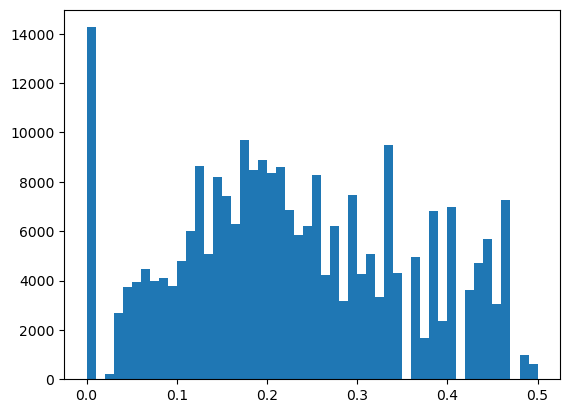

In [34]:
plt.hist(df_non['word_share'],bins=50)


In [35]:
(df_non['word_share']>0.42).sum()

22335

In [36]:
df_0 = df[(df["is_duplicate"] == 0) & (df['word_share'] <0.42)]


In [37]:
(df_dup['word_share']<0.23).sum()

26654

In [38]:
df_1=df_dup[df['word_share']>0.23]

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\813863152.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_1=df_dup[df['word_share']>0.23]


In [39]:
new_df=pd.concat([df_0,df_1],axis=0)

In [40]:
new_df

,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_total,word_common,word_share
1,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,48,81,10,15,24,7,0.29
2,how can i increa the speed of my internet conn...,how can internet speed be increas by hack thro...,0,65,52,14,10,24,4,0.17
3,whi am i mental veri lone how can i solv it,find the remaind when 23 24 math is divid by 2...,0,43,50,11,12,20,0,0.00
4,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water,0,70,37,13,7,20,4,0.20
6,should i buy tiago,what keep childern activ and far from phone an...,0,18,58,4,11,14,0,0.00
...,...,...,...,...,...,...,...,...,...,...
404280,what are some outfit idea to wear to a frat parti,what are some outfit idea wear to a frat theme...,1,49,52,11,11,21,10,0.48
404281,whi is manaphi childish in pokémon ranger and ...,whi is manaphi annoy in pokemon ranger and the...,1,66,63,13,13,24,10,0.42
404282,how doe a long distanc relationship work,how are long distanc relationship maintain,1,40,42,7,6,13,4,0.31
404284,what doe jainism say about homosexu,what doe jainism say about gay and homosexu,1,35,43,6,8,14,6,0.43


# EDA 1

C:\Users\Neon4\anconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


minimum characters 0
maximum characters 562
average num of characters 53


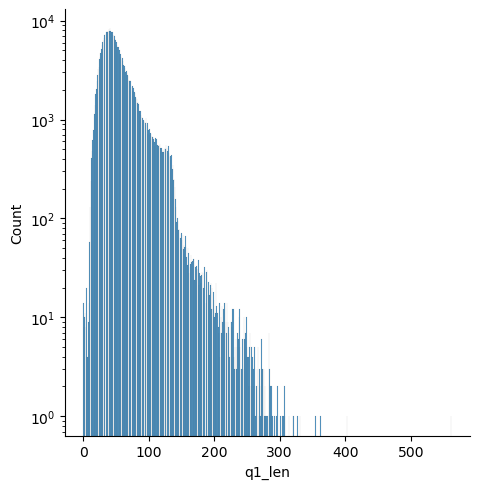

In [42]:
# Analysis of features
sns.displot(new_df['q1_len'])
plt.yscale('log')
print('minimum characters',new_df['q1_len'].min())
print('maximum characters',new_df['q1_len'].max())
print('average num of characters',int(new_df['q1_len'].mean()))

C:\Users\Neon4\anconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


minimum characters 0
maximum characters 1073
average num of characters 54


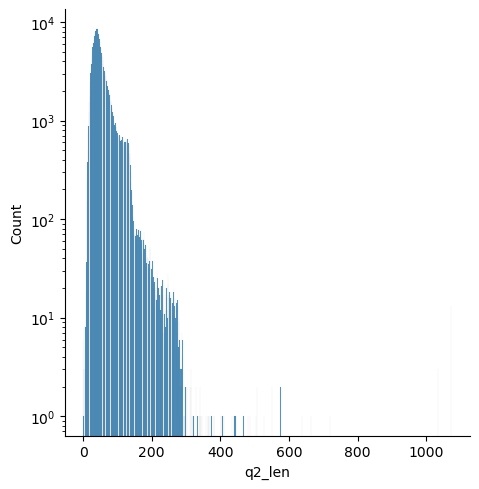

In [43]:
sns.displot(new_df['q2_len'])
plt.yscale('log')

print('minimum characters',new_df['q2_len'].min())
print('maximum characters',new_df['q2_len'].max())
print('average num of characters',int(new_df['q2_len'].mean()))

C:\Users\Neon4\anconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


minimum words 1
maximum words 128
average num of words 11


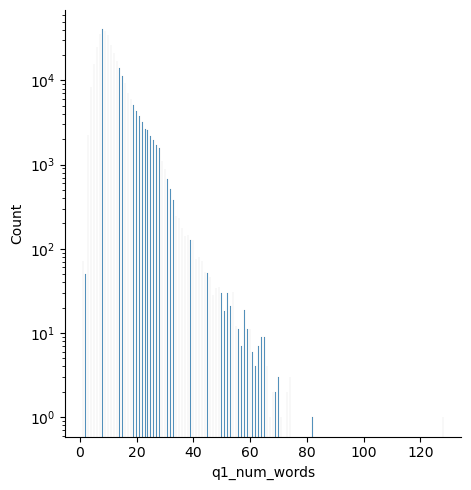

In [44]:
sns.displot(new_df['q1_num_words'])
plt.yscale('log')

print('minimum words',new_df['q1_num_words'].min())
print('maximum words',new_df['q1_num_words'].max())
print('average num of words',int(new_df['q1_num_words'].mean()))

C:\Users\Neon4\anconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


minimum words 1
maximum words 249
average num of words 11


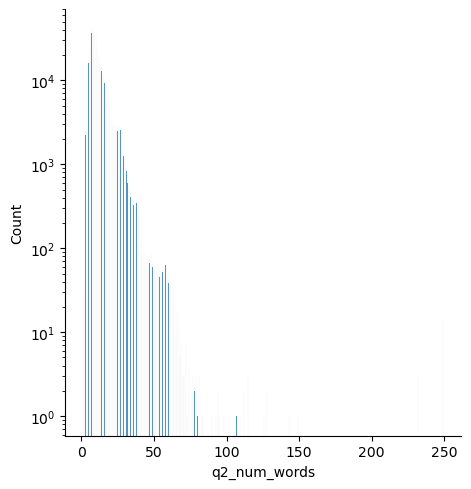

In [45]:
sns.displot(new_df['q2_num_words'])
plt.yscale('log')

print('minimum words',new_df['q2_num_words'].min())
print('maximum words',new_df['q2_num_words'].max())
print('average num of words',int(new_df['q2_num_words'].mean()))

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\461907782.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate',kde=False,bins=50)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\461907782.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5

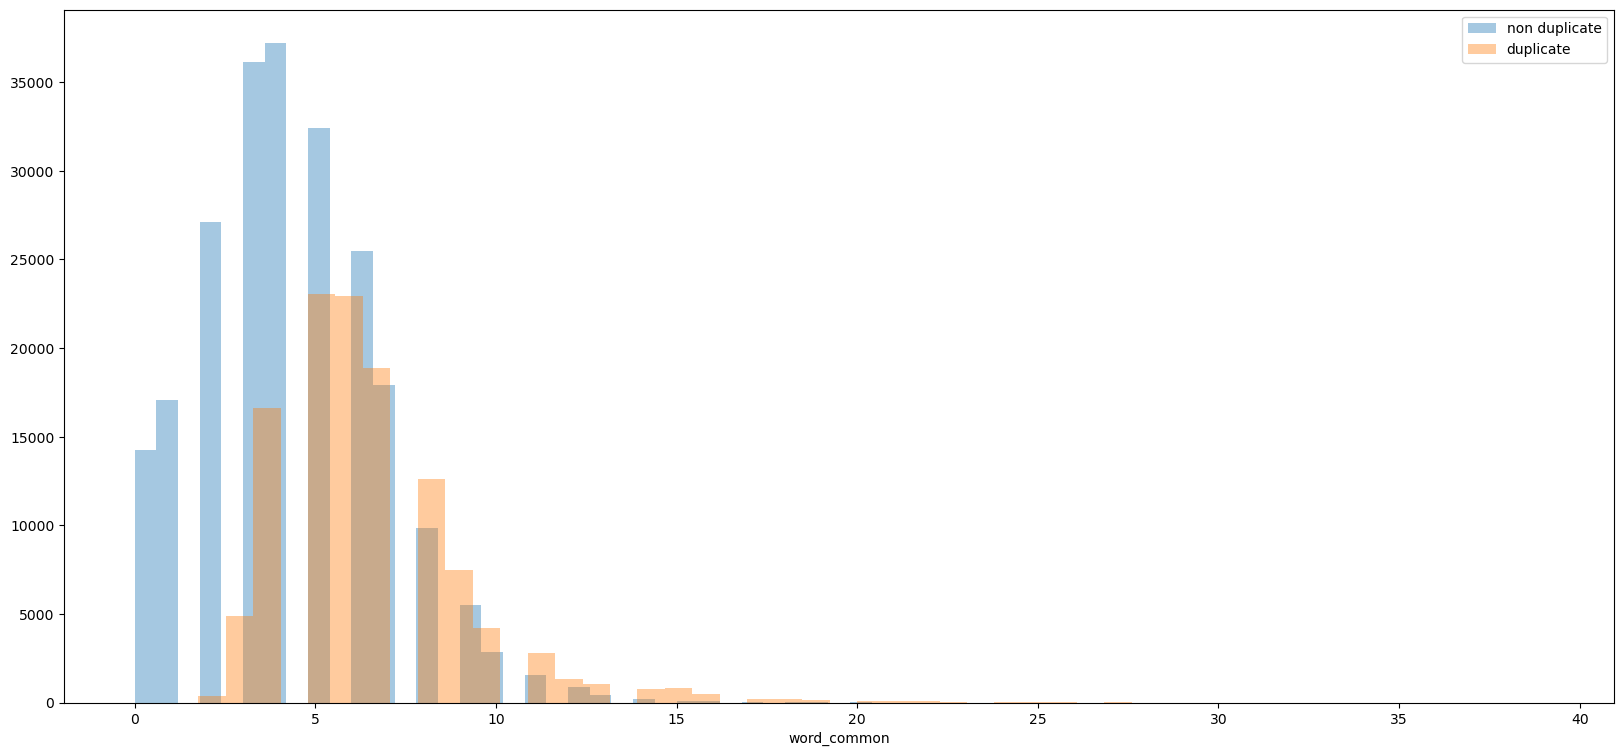

In [46]:
plt.figure(figsize=(20,9))
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_common'],label='non duplicate',kde=False,bins=50)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_common'],label='duplicate',kde=False,bins=50)
plt.legend()
plt.show()

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\635792968.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate',bins=50)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\635792968.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.

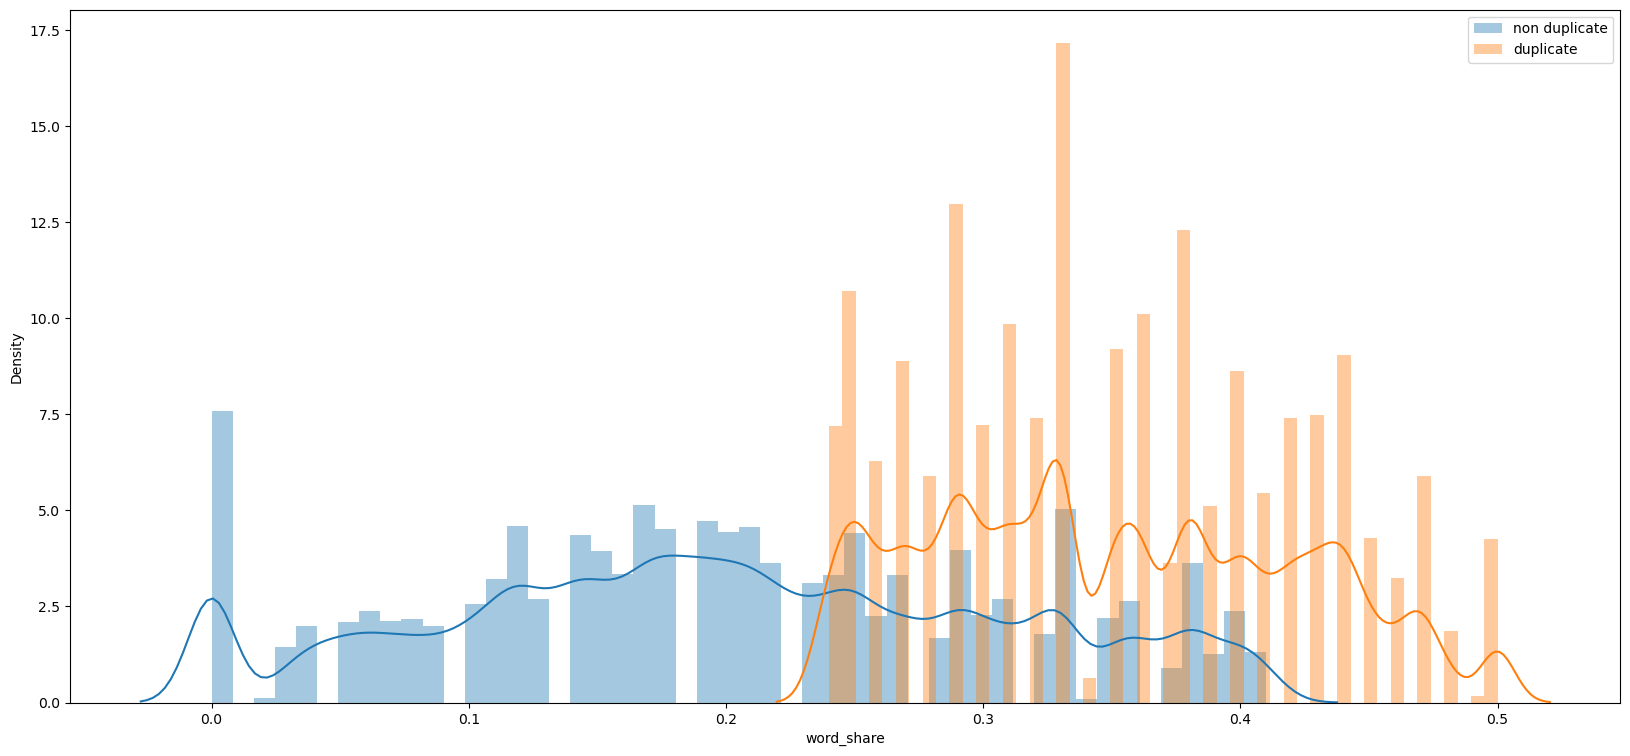

In [47]:
plt.figure(figsize=(20,9))
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_share'],label='non duplicate',bins=50)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_share'],label='duplicate',bins=50)
plt.legend()
plt.show()

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\2776808923.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\2776808923.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distpl

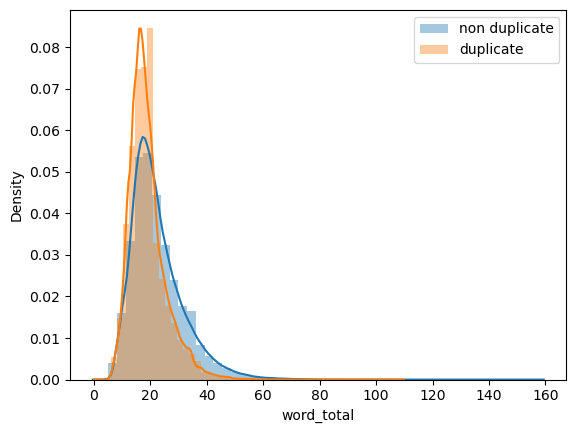

In [48]:
# total words
sns.distplot(new_df[new_df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(new_df[new_df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

# advance Feature creation

1 q1_t =no. of tokens in q1

2 q2_t =no. of tokens in q2

3 q1_s =no. of stopwords in q1 

4 q2_s =no. of stopwords in q2 



5 csc =  count of common stopwords

6 ctc = count of common  tokens 

7 cwc_min = count of common words between q1 and q2 divide by min no.of words in q1 or q2

8  cwc_max = count of common words between q1 and q2 divide by max no.of words in q1 or q2

9csc_min= count of common stopwords between q1 and q2 divide by min no.of stopwords in q1 or q2

10 csc_max= count of common stopwords between q1 and q2 divide by max no.of stopwords in q1 or q2

11 ctc_min = count of common tokens between q1 and q2 divide by min no.of tokens in q1 or q2

12 ctc_max = count of common tokens between q1 and q2 divide by max no.of tokens in q1 or q2

13 first_w_eq= 1 if first words of q1 and q2 are equal

14 last_w_eq= 1 if last words of q1 and q2 are equal

In [49]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter

In [52]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Neon4\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Neon4\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
def count_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    stopword_count = sum(1 for token in tokens if token.lower() in stop_words)
    return stopword_count


Features 1 to 4

In [54]:
new_df['q1_s']=new_df['question1'].swifter.apply(count_stopwords)

Pandas Apply:   0%|          | 0/348249 [00:00<?, ?it/s]

In [55]:
new_df['q2_s']=new_df['question2'].swifter.apply(count_stopwords)

Pandas Apply:   0%|          | 0/348249 [00:00<?, ?it/s]

In [56]:
new_df['q1_t']=new_df['q1_num_words']-new_df['q1_s'] 
new_df['q2_t']=new_df['q2_num_words']-new_df['q2_s']

feature 5 and 6

In [58]:
def count_common_tokens(row):
    stop_words = set(stopwords.words('english'))
    
    # Extract values from the row
    q1 = row['question1']
    q2 = row['question2']
    
    # Tokenize the words in each question
    tokens_q1 = word_tokenize(q1)
    tokens_q2 = word_tokenize(q2)
    
    # Convert tokens comparison
    tokens_q1 = set(token for token in tokens_q1 if token not in stop_words)
    tokens_q2 = set(token for token in tokens_q2 if token not in stop_words)
    
    # Find the common stopwords
    common_tokens = tokens_q1.intersection(tokens_q2)
    
    return len(common_tokens) 

In [59]:
new_df['ctc']=new_df[['question1','question2']].swifter.apply(count_common_tokens, axis=1)

Pandas Apply:   0%|          | 0/348249 [00:00<?, ?it/s]

In [70]:
new_df['csc']=new_df['word_common']-new_df['ctc']

Feature 7 to 12

In [78]:
new_df['cwc_min'] = new_df['word_common'] / (new_df[['q1_num_words', 'q2_num_words']].min(axis=1))
new_df['cwc_max']= new_df['word_common'] / new_df[['q1_num_words', 'q2_num_words']].max(axis=1)


In [79]:
new_df['cwc_min'] = new_df['cwc_min'].round(3)
new_df['cwc_max'] = new_df['cwc_max'].round(3)

# removing questions only containg stop words and only tokens

In [99]:
new_df.shape

(348249, 22)

In [103]:
new_df=new_df[(new_df['q1_t']!=0)&(new_df['q2_t']!=0)&(new_df['q2_s']!=0)&(new_df['q1_s']!=0)]

In [104]:
new_df.shape

(344204, 22)

In [105]:
new_df['ctc_min']=new_df['ctc'] / new_df[['q1_t', 'q2_t']].min(axis=1)
new_df['ctc_max']=new_df['ctc'] / new_df[['q1_t', 'q2_t']].max(axis=1)

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\2882870639.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ctc_min']=new_df['ctc'] / new_df[['q1_t', 'q2_t']].min(axis=1)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\2882870639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ctc_max']=new_df['ctc'] / new_df[['q1_t', 'q2_t']].max(axis=1)


In [106]:
new_df['ctc_max']=new_df['ctc_max'].round(3)
new_df['ctc_min']=new_df['ctc_min'].round(3)

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\667163712.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ctc_max']=new_df['ctc_max'].round(3)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\667163712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['ctc_min']=new_df['ctc_min'].round(3)


In [107]:
new_df['csc_min']= new_df['csc'] / new_df[['q1_s', 'q2_s']].min(axis=1)
new_df['csc_max']= new_df['csc'] / new_df[['q1_s', 'q2_s']].max(axis=1)

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\620732124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['csc_min']= new_df['csc'] / new_df[['q1_s', 'q2_s']].min(axis=1)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\620732124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['csc_max']= new_df['csc'] / new_df[['q1_s', 'q2_s']].max(axis=1)


In [108]:
new_df['csc_min'] = new_df['csc_min'].round(3)
new_df['csc_max'] = new_df['csc_max'].round(3)

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\1286014478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['csc_min'] = new_df['csc_min'].round(3)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\1286014478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['csc_max'] = new_df['csc_max'].round(3)


feature 13 and 14

In [110]:
def are_first_words_equal(row):
    # Extract values from the row
    q1 = row['question1']
    q2 = row['question2']
    
    # Tokenize the words in each question
    tokens_q1 = word_tokenize(q1)
    tokens_q2 = word_tokenize(q2)
    
    # Check if the first words are equal (case-insensitive)
    first_word_q1 = tokens_q1[0] if tokens_q1 else None
    first_word_q2 = tokens_q2[0] if tokens_q2 else None
    
    return 1 if first_word_q1 == first_word_q2 else 0

In [111]:
new_df['first_w_eq']=new_df[['question1','question2']].swifter.apply(are_first_words_equal, axis=1)

Pandas Apply:   0%|          | 0/344204 [00:00<?, ?it/s]

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\1976285059.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['first_w_eq']=new_df[['question1','question2']].swifter.apply(are_first_words_equal, axis=1)


In [112]:
def are_last_words_equal(row):
    # Extract values from the row
    q1 = row['question1']
    q2 = row['question2']
    
    # Tokenize the words in each question
    tokens_q1 = word_tokenize(q1)
    tokens_q2 = word_tokenize(q2)
    
    # Check if the first words are equal (case-insensitive)
    first_word_q1 = tokens_q1[-1] if tokens_q1 else None
    first_word_q2 = tokens_q2[-1] if tokens_q2 else None
    
    return 1 if first_word_q1 == first_word_q2 else 0

In [113]:
new_df['last_w_eq']=new_df[['question1','question2']].swifter.apply(are_last_words_equal, axis=1)

Pandas Apply:   0%|          | 0/344204 [00:00<?, ?it/s]

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\1685701210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['last_w_eq']=new_df[['question1','question2']].swifter.apply(are_last_words_equal, axis=1)


In [114]:
new_df['avg_words']=new_df['word_total']/2

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\528256314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['avg_words']=new_df['word_total']/2


# EDA 2

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\2374662770.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['cwc_min'],label='non duplicate',kde=False,bins=30)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\2374662770.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe575

Text(0.5, 1.0, 'cwc_max')

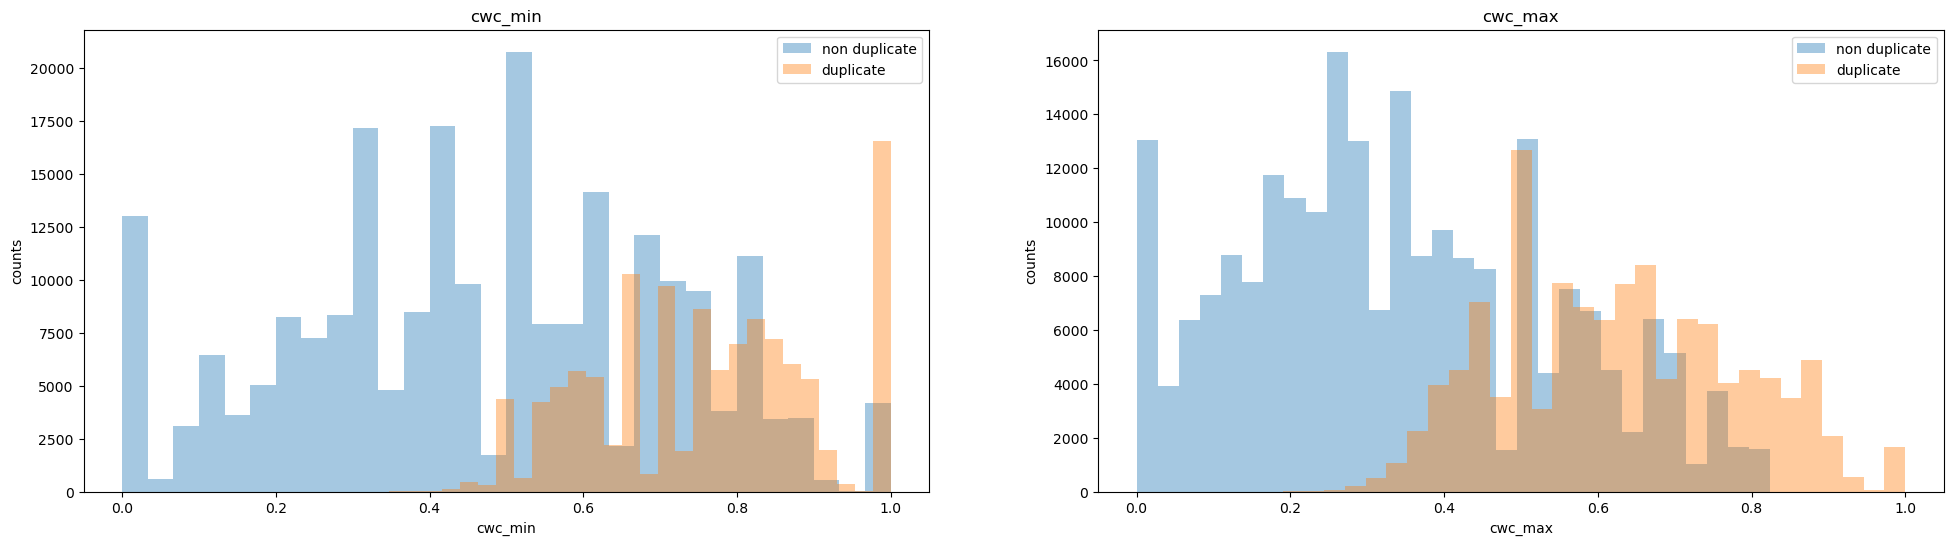

In [115]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['cwc_min'],label='non duplicate',kde=False,bins=30)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['cwc_min'],label='duplicate',kde=False,bins=30)
plt.legend()
plt.ylabel('counts')
plt.title('cwc_min')

plt.subplot(1,2,2)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['cwc_max'],label='non duplicate',kde=False,bins=30)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['cwc_max'],label='duplicate',kde=False,bins=30)
plt.legend()
plt.ylabel('counts')
plt.title('cwc_max')

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\1071049302.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['csc_min'],label='non duplicate',kde=False,bins=10)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\1071049302.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe575

Text(0.5, 1.0, 'csc_max')

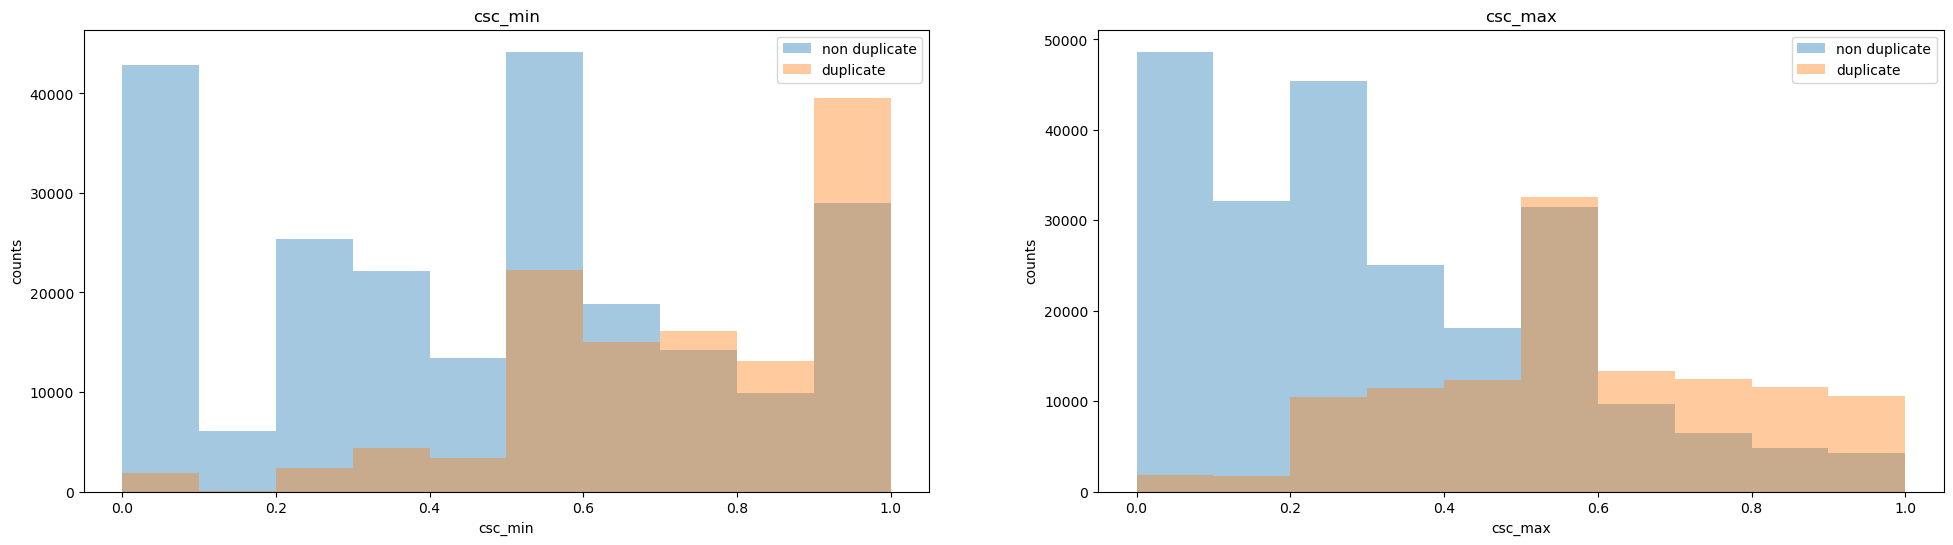

In [116]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['csc_min'],label='non duplicate',kde=False,bins=10)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['csc_min'],label='duplicate',kde=False,bins=10)
plt.legend()
plt.ylabel('counts')
plt.title('csc_min')

plt.subplot(1,2,2)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['csc_max'],label='non duplicate',kde=False,bins=10)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['csc_max'],label='duplicate',kde=False,bins=10)
plt.legend()
plt.ylabel('counts')
plt.title('csc_max')

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\1416298952.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['ctc_min'],label='non duplicate',kde=False,bins=10)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\1416298952.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe575

Text(0.5, 1.0, 'ctc_max')

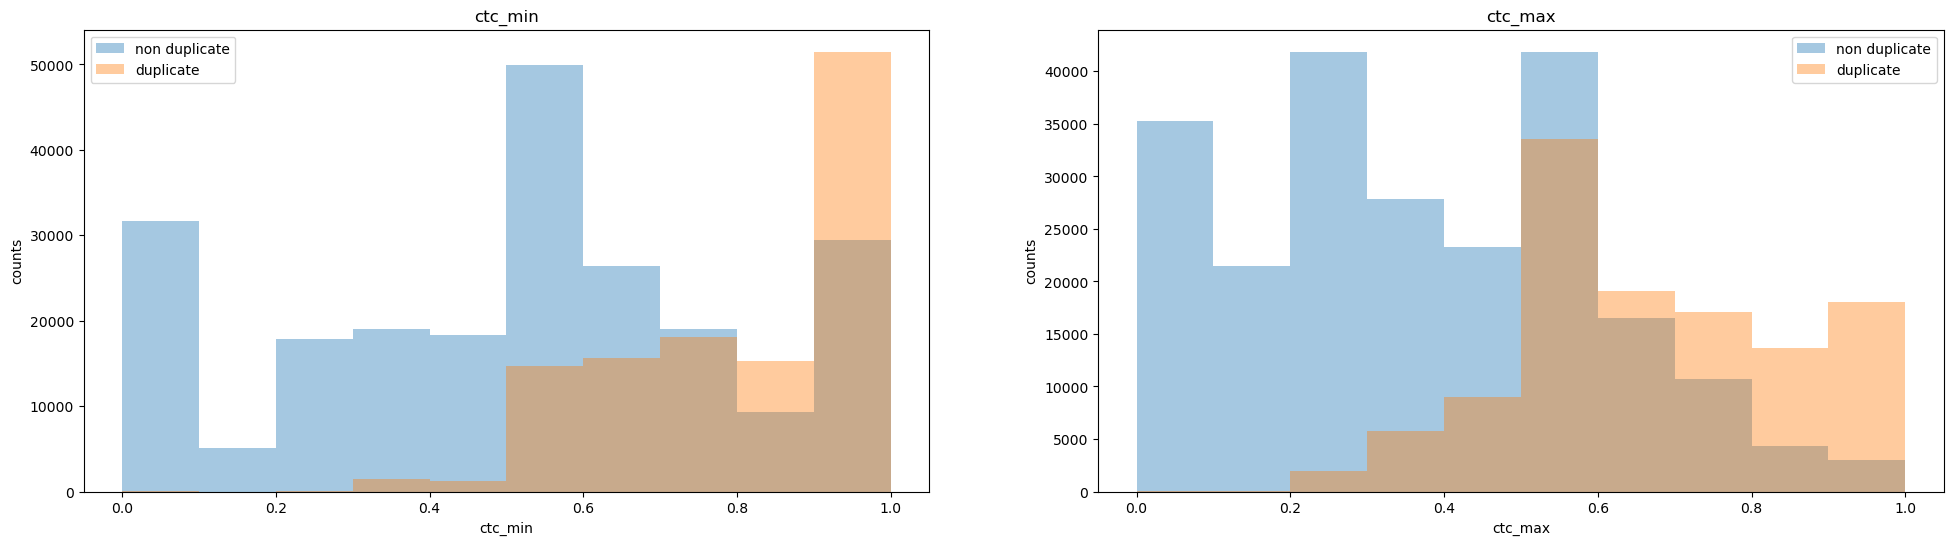

In [117]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['ctc_min'],label='non duplicate',kde=False,bins=10)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['ctc_min'],label='duplicate',kde=False,bins=10)
plt.legend()
plt.ylabel('counts')
plt.title('ctc_min')

plt.subplot(1,2,2)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['ctc_max'],label='non duplicate',kde=False,bins=10)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['ctc_max'],label='duplicate',kde=False,bins=10)
plt.legend()
plt.ylabel('counts')
plt.title('ctc_max')

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\3264017665.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['first_w_eq'],label='non duplicate',kde=False,bins=2)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\3264017665.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5

Text(0.5, 1.0, 'ctc_max')

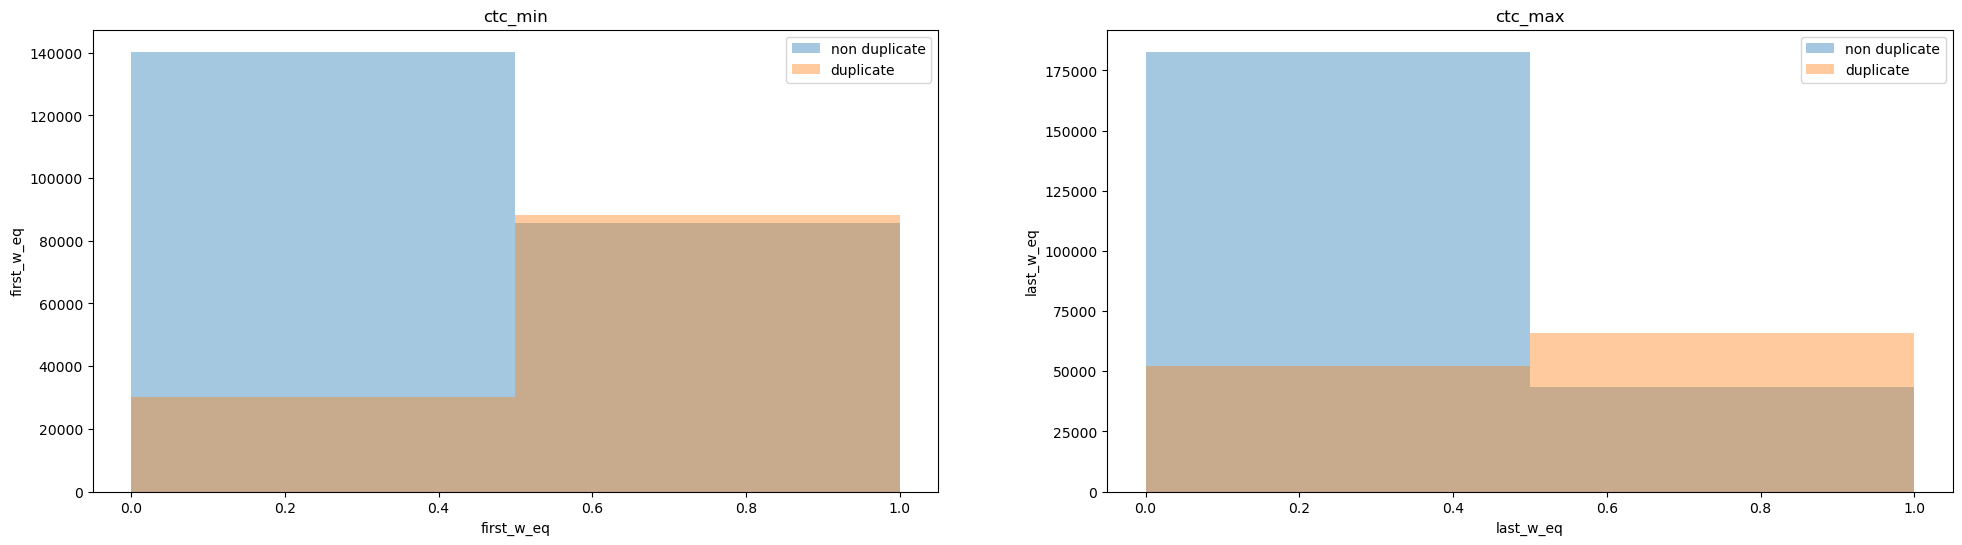

In [118]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['first_w_eq'],label='non duplicate',kde=False,bins=2)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['first_w_eq'],label='duplicate',kde=False,bins=2)
plt.legend()
plt.ylabel('first_w_eq')
plt.title('ctc_min')

plt.subplot(1,2,2)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['last_w_eq'],label='non duplicate',kde=False,bins=2)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['last_w_eq'],label='duplicate',kde=False,bins=2)
plt.legend()
plt.ylabel('last_w_eq')
plt.title('ctc_max')

C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\739589202.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df[new_df['is_duplicate'] == 0]['ctc'],label='non duplicate',kde=False,bins=2)
C:\Users\Neon4\AppData\Local\Temp\ipykernel_10840\739589202.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

Text(0.5, 1.0, 'csc')

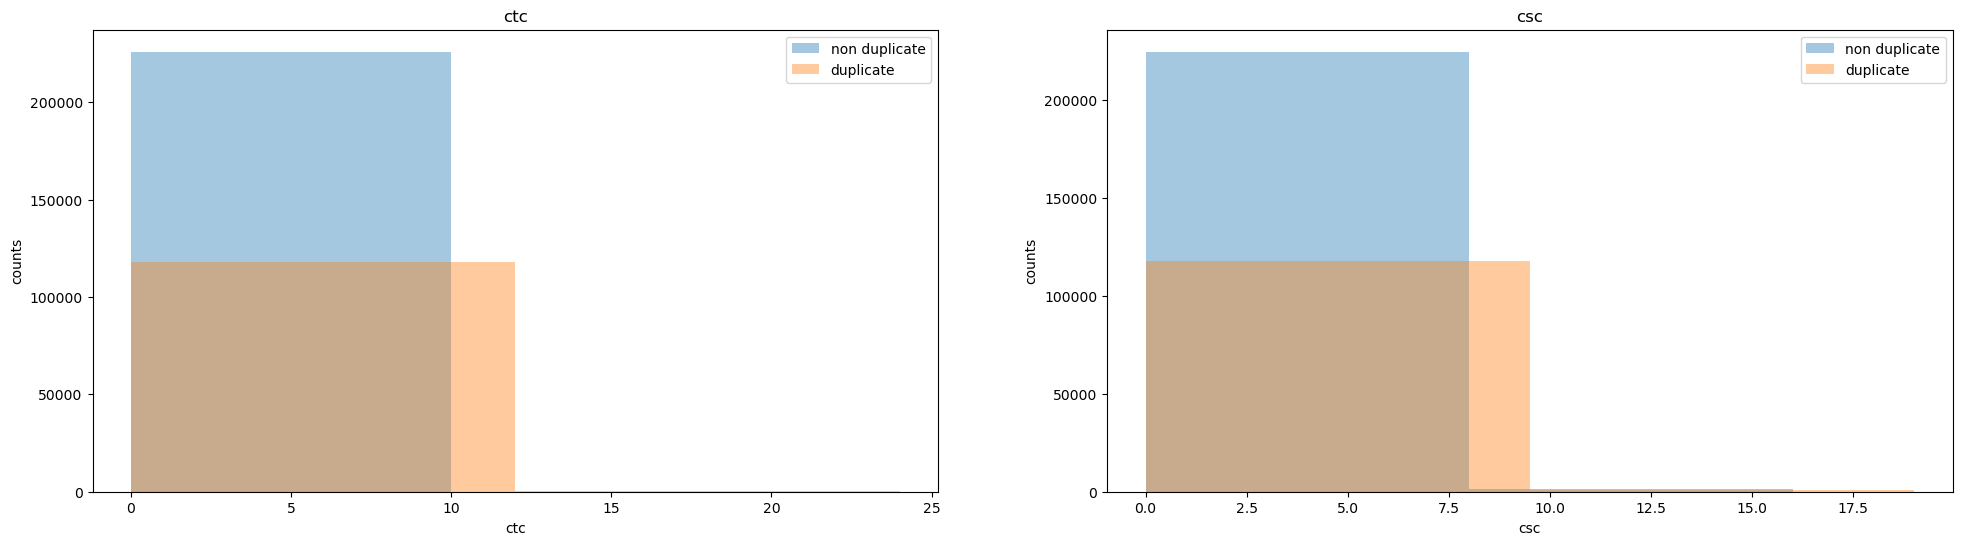

In [119]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['ctc'],label='non duplicate',kde=False,bins=2)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['ctc'],label='duplicate',kde=False,bins=2)
plt.legend()
plt.ylabel('counts')
plt.title('ctc')

plt.subplot(1,2,2)
sns.distplot(new_df[new_df['is_duplicate'] == 0]['csc'],label='non duplicate',kde=False,bins=2)
sns.distplot(new_df[new_df['is_duplicate'] == 1]['csc'],label='duplicate',kde=False,bins=2)
plt.legend()
plt.ylabel('counts')
plt.title('csc')

# Traning models

In [121]:
new_df

,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_total,word_common,word_share,...,csc,cwc_min,cwc_max,ctc_min,ctc_max,csc_min,csc_max,first_w_eq,last_w_eq,avg_words
1,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...,0,48,81,10,15,24,7,0.29,...,3,0.700,0.467,0.800,0.400,0.600,0.600,1,0,12.0
2,how can i increa the speed of my internet conn...,how can internet speed be increas by hack thro...,0,65,52,14,10,24,4,0.17,...,2,0.400,0.286,0.400,0.333,0.400,0.250,1,0,12.0
3,whi am i mental veri lone how can i solv it,find the remaind when 23 24 math is divid by 2...,0,43,50,11,12,20,0,0.00,...,0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,10.0
4,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water,0,70,37,13,7,20,4,0.20,...,2,0.571,0.308,0.400,0.200,1.000,0.667,1,0,10.0
6,should i buy tiago,what keep childern activ and far from phone an...,0,18,58,4,11,14,0,0.00,...,0,0.000,0.000,0.000,0.000,0.000,0.000,0,0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404280,what are some outfit idea to wear to a frat parti,what are some outfit idea wear to a frat theme...,1,49,52,11,11,21,10,0.48,...,5,0.909,0.909,1.000,0.833,1.000,0.833,1,1,10.5
404281,whi is manaphi childish in pokémon ranger and ...,whi is manaphi annoy in pokemon ranger and the...,1,66,63,13,13,24,10,0.42,...,5,0.769,0.769,0.714,0.714,0.833,0.833,1,1,12.0
404282,how doe a long distanc relationship work,how are long distanc relationship maintain,1,40,42,7,6,13,4,0.31,...,1,0.667,0.571,0.750,0.600,0.500,0.500,1,0,6.5
404284,what doe jainism say about homosexu,what doe jainism say about gay and homosexu,1,35,43,6,8,14,6,0.43,...,2,1.000,0.750,1.000,0.800,1.000,0.667,1,1,7.0


In [126]:
new_df.to_csv(r'C:\Users\Neon4\Machine learning code\project code\Qura question pair project\data\df.csv',index=False)